The datasets were downloaded from https://www.kaggle.com/c/tweet-sentiment-extraction. They are datasets in an ongoing kaggle competition called Tweet Sentiment Extraction. However, this competition is not like traditional sentiment analysis competitions asking for sentiment scores, it asked us to extract part of the tweet (word or phrase) that reflects the sentiment. 

Caution: I don't use these datasets to do the tasks of what kaggle asked, because I don't think the selected texts in the trainning data set make sense(there are a lot of similar complains among competitors). But I really like the datasets. Therefore, I use these datasets to build supervised sentiment classifiers.

This project is mainly about sentiment analysis. It is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. Sentiment analysis allows businesses to identify customer sentiment toward products, brands or services in online conversations and feedback.

The essence of sentiment analysis is text (multi) classification. In my datasets, both the train and the test are well labled with whether the twitter text is positive, neutral or negative. I will build supervised models to classify them from scratch.

In [0]:
# use google colab to gain better calculation power 
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


- Importing Necesseties

In [148]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


- Data Ingestion

In [0]:
PROJ_DIR = r"/content/drive/My Drive/projects/t81_577_datascience"
DATA_DIR = os.path.join(PROJ_DIR, "Data")
train_file= os.path.join(DATA_DIR, 'train.csv')
test_file = os.path.join(DATA_DIR, 'test.csv')

In [0]:
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

In [153]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [154]:
display(train)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [155]:
display(test)

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive
...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative
3530,416863ce47,All alone in this old house again. Thanks for...,positive
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive


In [0]:
# I don'y need the selected text column because I don't use these datasets to do the tasks of what kaggle asked
train = train.drop(['selected_text'], axis=1)

In [0]:
# check if there are null values in the datasets
print(f"train data has na? {pd.isnull(train).values.any()}")
print(f"test data has na? {pd.isnull(test).values.any()}")

train data has na? True
test data has na? False


In [0]:
train.dropna(axis=0, inplace=True)

In [0]:
train.describe()

,textID,text,sentiment
count,27480,27480,27480
unique,27480,27480,3
top,b3261627a4,someone broke into my car big time = having a ...,neutral
freq,1,1,11117


- Exploratory Data Analysis (EDA) & Visualization

Let's look at the sentiment distribution of tweets in the train set.

In [0]:
train_sentiment = train.groupby("sentiment").count().reset_index()
train_sentiment

,sentiment,textID,text
0,negative,7781,7781
1,neutral,11117,11117
2,positive,8582,8582


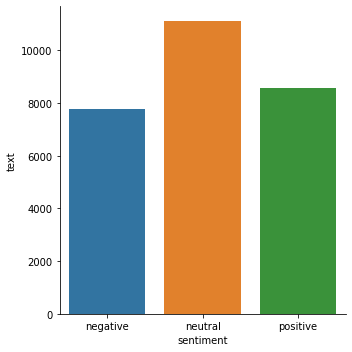

In [0]:
sns.catplot(x = "sentiment", y = "text", data = train_sentiment, kind = "bar");

Let's look at the sentiment distribution of tweets in the test set.

In [0]:
test_sentiment = test.groupby("sentiment").count().reset_index()
test_sentiment

,sentiment,textID,text
0,negative,1001,1001
1,neutral,1430,1430
2,positive,1103,1103


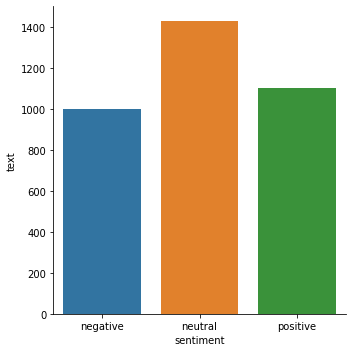

In [0]:
sns.catplot(x = "sentiment", y = "text", data = test_sentiment, kind = "bar");

The sentiment distribution of tweets in the train and test sets are consistant. 

Now let's see whether the word count of each twitter has anything to do with the sentiment.

In [0]:
train["text_wordcount"] = train["text"].str.split().str.len()

In [0]:
train_negative = train.loc[train["sentiment"]== "negative"]
train_neutral = train.loc[train["sentiment"]== "neutral"]
train_positive = train.loc[train["sentiment"]== "positive"]

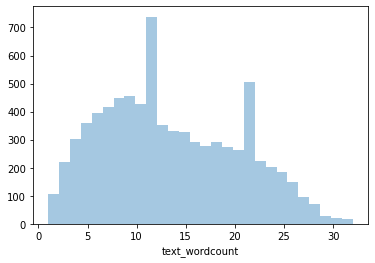

In [0]:
sns.distplot(train_negative["text_wordcount"],kde = False);

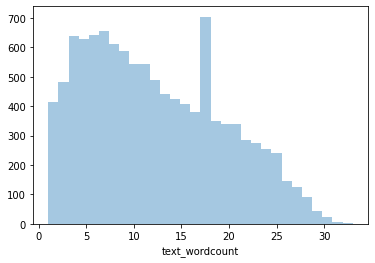

In [0]:
sns.distplot(train_neutral["text_wordcount"],kde = False);

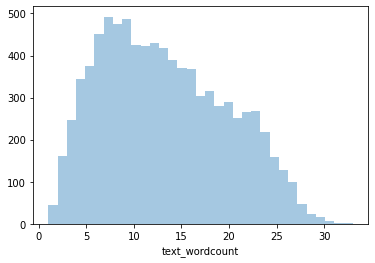

In [0]:
sns.distplot(train_positive["text_wordcount"],kde = False);

The distribution of word count for different sentiments are different. Let's see the test data.

In [0]:
test["text_wordcount"] = test["text"].str.split().str.len()

In [0]:
test_negative = test.loc[test["sentiment"]== "negative"]
test_neutral = test.loc[test["sentiment"]== "neutral"]
test_positive = test.loc[test["sentiment"]== "positive"]

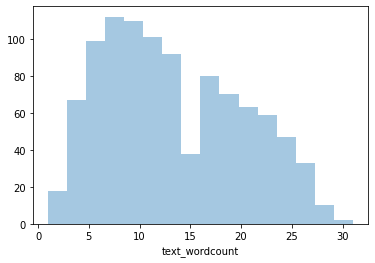

In [0]:
sns.distplot(test_negative["text_wordcount"],kde = False);

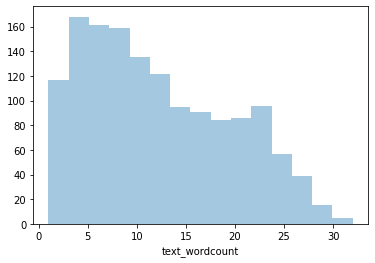

In [0]:
sns.distplot(test_neutral["text_wordcount"],kde = False);

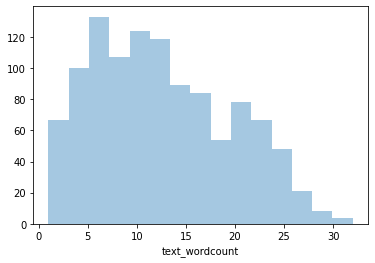

In [0]:
sns.distplot(test_positive["text_wordcount"],kde = False);

For text wordcount, the distribution shape of the text dataset is not consistant with the the distribution shape of the train dataset. Therefore, in further modeling, the text_wordcount might not be a very good feature to choose.

Let's see the common words for twitters of different sentiment. We need to preprocess the texts first.

In [0]:
def text_preprocessing(df_text):
  """
  Basic preprocessing for text in pandas dataframe,
  including lower casing, punctuation removal, stopwords removal,
  frequent words removal, lemmatization.

  Arguments
  df_text: the text column in a pandas dataframe

  Returns
  the preprocessed text column in a pandas dataframe
  """
  # convert the text type to unicode
  # df_text = df_text.values.astype('U')
  # lower casing
  df_text = df_text.apply(lambda x: " ".join(x.lower() for x in x.split()))
  # punctuation removal
  df_text = df_text.str.replace('[^\w\s]','')
  # stopwords removal
  stop_words = set(stopwords.words('english')) 
  df_text  = df_text.apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
  #Frequent words removal
  freq = pd.Series(' '.join(df_text).split()).value_counts()[:20]
  freq = list(freq.index)
  df_text = df_text.apply(lambda x: " ".join(x for x in x.split() if x not in freq))
  # Lemmatization, I only want root words
  lemmatizer = nltk.stem.WordNetLemmatizer()
  df_text  = df_text.apply(lambda x: lemmatizer.lemmatize(x))

  return df_text

In [0]:
train['text'] = text_preprocessing(train['text'])
test['text'] = text_preprocessing(test['text'])

In [0]:
display(train)

,textID,text,sentiment,text_wordcount
0,cb774db0d1,id responded,neutral,7
1,549e992a42,sooo sad miss san diego,negative,10
2,088c60f138,boss bullying,negative,5
3,9642c003ef,interview leave alone,negative,5
4,358bd9e861,sons couldnt put releases already bought,negative,14
...,...,...,...,...
27476,4eac33d1c0,wish could come see denver husband lost job af...,negative,16
27477,4f4c4fc327,ive wondered rake client made clear net force ...,negative,23
27478,f67aae2310,yay enjoy break probably need hectic weekend t...,positive,22
27479,ed167662a5,worth,positive,6


In [0]:
display(test)

,textID,text,sentiment,text_wordcount
0,f87dea47db,last session httptwitpiccom67ezh,neutral,6
1,96d74cb729,shanghai also really exciting precisely skyscr...,positive,15
2,eee518ae67,recession hit veronique branquinho quit compan...,negative,13
3,01082688c6,bday,positive,2
4,33987a8ee5,httptwitpiccom4w75p,positive,5
...,...,...,...,...
3529,e5f0e6ef4b,3 tired sleep try,negative,15
3530,416863ce47,alone old house thanks net keeps alive kicking...,positive,26
3531,6332da480c,mean little dog sinking depression wants move ...,negative,18
3532,df1baec676,_sutra next youtube video gonna videos,positive,14


Let's take a look at most common words of the whole train dataset and don't distinguish sentiments first.

In [0]:
train['temp_list1'] = train['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp

,Common_words,count
1,see,797
2,well,744
3,new,740
4,night,737
5,home,716
6,want,714
7,think,705
8,still,679
9,mothers,677
10,2,664


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3692: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


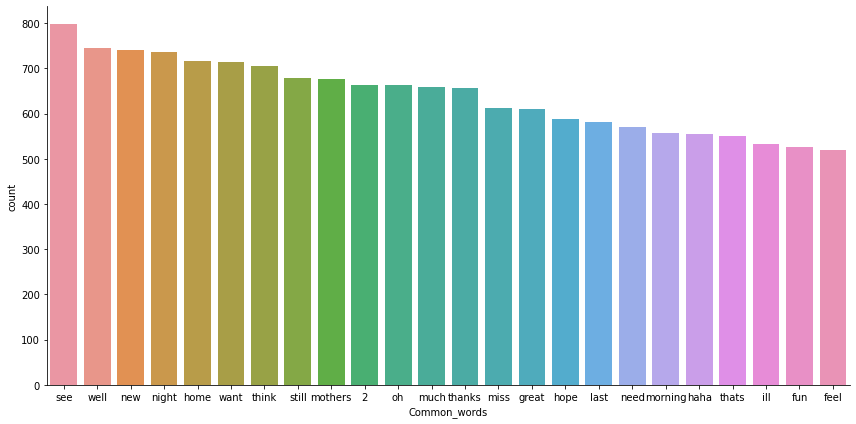

In [0]:
sns.catplot(x = "Common_words", y = "count", data = temp, kind = "bar",size=6, aspect=2);

Now let's look at most common words in different sentiments.

In [0]:
positive_sent = train[train['sentiment']=='positive']
negative_sent = train[train['sentiment']=='negative']
neutral_sent = train[train['sentiment']=='neutral']

In [0]:
#most common positive words
top = Counter([item for sublist in positive_sent['temp_list1'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive

,Common_words,count
0,mothers,591
1,thanks,553
2,great,478
3,hope,396
4,fun,344
5,nice,334
6,night,319
7,morning,288
8,see,273
9,new,271


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3692: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


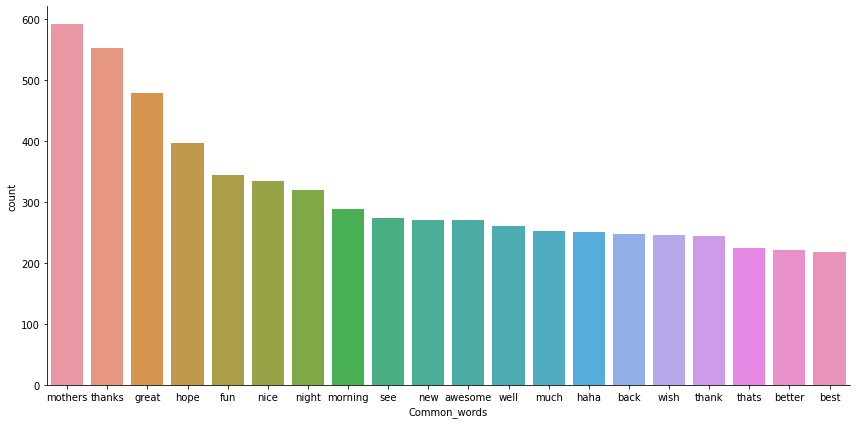

In [0]:
sns.catplot(x = "Common_words", y = "count", data = temp_positive, kind = "bar",size=6, aspect=2);

In [0]:
#most common negative words
top = Counter([item for sublist in negative_sent['temp_list1'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative

,Common_words,count
1,sad,389
2,sorry,340
3,bad,300
4,feel,286
5,hate,262
6,want,245
7,still,243
8,back,234
9,oh,228
10,think,225


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3692: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


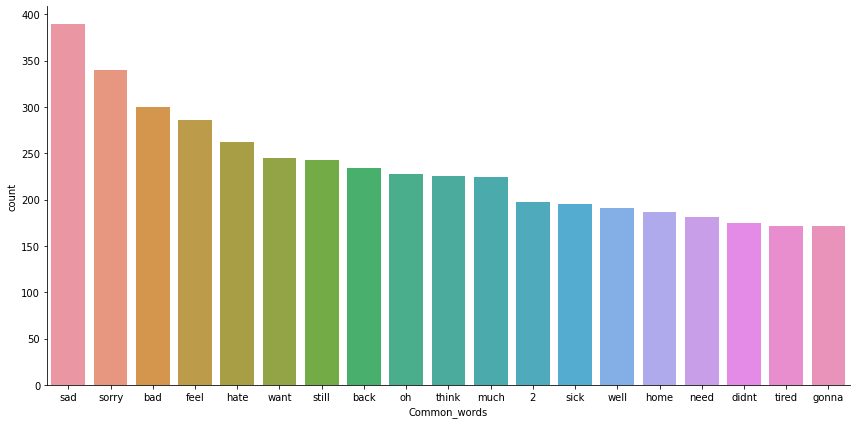

In [0]:
sns.catplot(x = "Common_words", y = "count", data = temp_negative, kind = "bar",size=6, aspect=2);

In [0]:
#most common neutral words
top = Counter([item for sublist in neutral_sent['temp_list1'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral

,Common_words,count
1,see,353
2,home,336
3,want,325
4,new,320
5,2,297
6,well,292
7,think,289
8,still,281
9,night,271
10,need,266


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3692: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


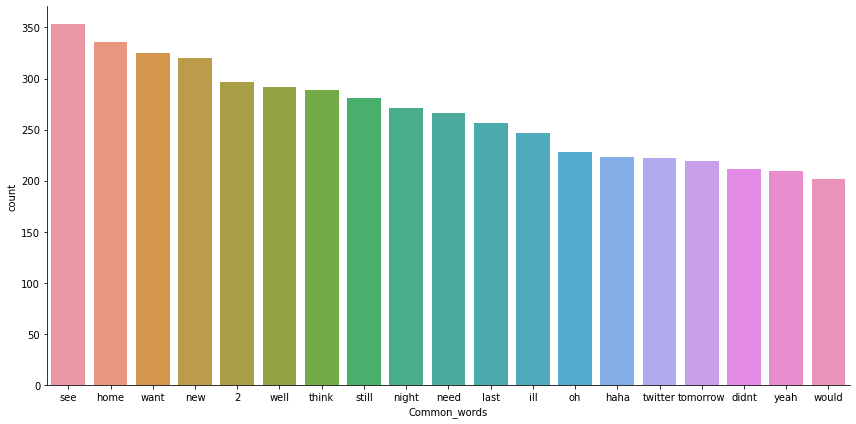

In [0]:
sns.catplot(x = "Common_words", y = "count", data = temp_neutral, kind = "bar",size=6, aspect=2);

We can see here that the most common words have obvious sentiment bias. For example, the most common words in positive twitters are "thanks", "great", "hope", "fun", etc. normally positive words. The most common words in negative twitters are "sad", "sorry", "bad", "hate", etc. normally negative words. The most common words in neutral twitters are "see", "home", "think", "need", etc. normally neutral words. Therefore, we have evidence that we may be able to use TF-IDF(Term Frequency — Inverse Document Frequency) method to build our model feature, because it reflects how relevant a term is in a given document.

Now I am going to build wordclouds for each sentiment. Here I refer to "Mr_KnowNothing" 's work on kaggle: https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model

In [0]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=80, figure_size=(10,6), color = 'white',
                   title = None, title_size=20, image_color=False):
    """
    Plot wordclouds.

    Arguments
    text: the text which is needed to plot wordcloud
    title: the title you want to show on the wordcloud
    other arguments like mask, max_words, max_font_size, figure_size, color
    decide the format of the wordcloud, this function has defined default values.
    
    """
    wordcloud = WordCloud(background_color=color,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
  
    plt.imshow(wordcloud);
    plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

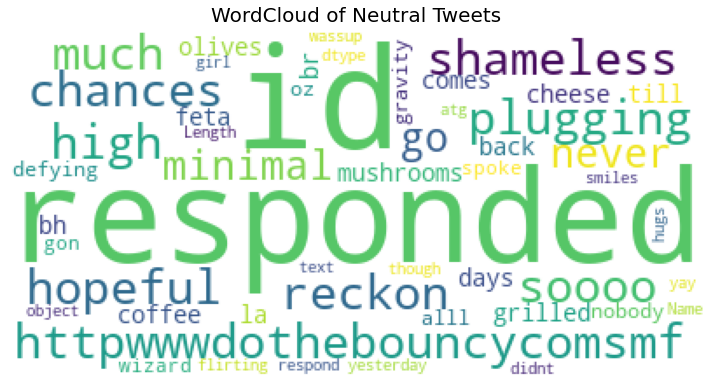

In [0]:
plot_wordcloud(neutral_sent.text,title="WordCloud of Neutral Tweets")

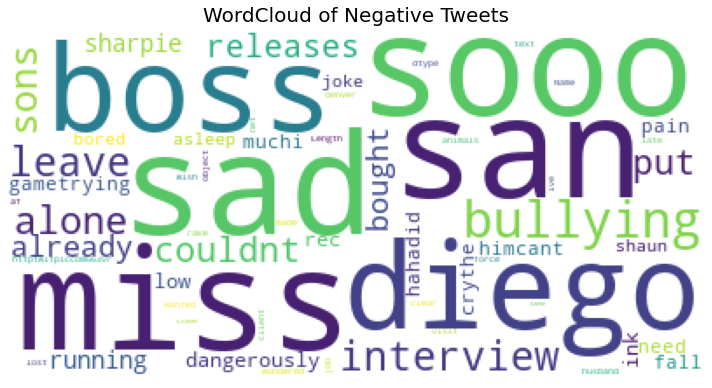

In [0]:
plot_wordcloud(negative_sent.text,title="WordCloud of Negative Tweets")

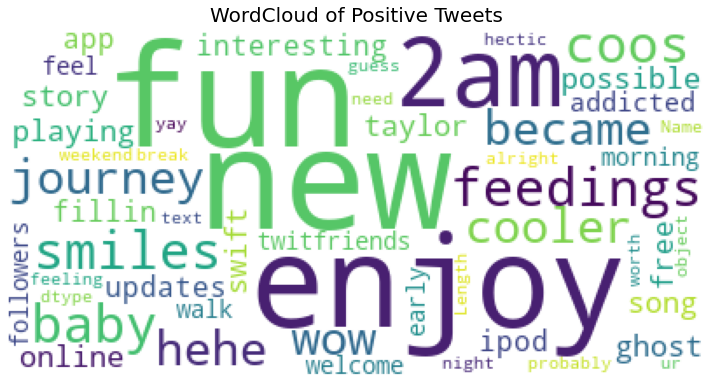

In [0]:
plot_wordcloud(positive_sent.text,title="WordCloud of Positive Tweets")

- Pre-Processing

In the EDA and Visulization part, I have conducted pre-processings like lower casing, punctuation removal, stopwords removal, frequent words removal, lemmatization, etc. However, before modeling, we need to convert the texts into features that models understand. Here I use TfidfVectorizer.

In [0]:
tfv = TfidfVectorizer()
tfv.fit(list(train['text'].values) + list(test['text'].values))
xtrain =  tfv.transform(train['text'].values).toarray() 
xtest = tfv.transform(test['text'].values).toarray()

In [0]:
xtrain

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
# encode the three kindf of sentiments to 0,1,2
train["sentiment"] = pd.Categorical(train["sentiment"])
train["target"] = train.sentiment.cat.codes
test["sentiment"] = pd.Categorical(test["sentiment"])
test["target"] = test.sentiment.cat.codes

In [0]:
train

,textID,text,sentiment,text_wordcount,temp_list1,target
0,cb774db0d1,id responded,neutral,7,"[id, responded]",1
1,549e992a42,sooo sad miss san diego,negative,10,"[sooo, sad, miss, san, diego]",0
2,088c60f138,boss bullying,negative,5,"[boss, bullying]",0
3,9642c003ef,interview leave alone,negative,5,"[interview, leave, alone]",0
4,358bd9e861,sons couldnt put releases already bought,negative,14,"[sons, couldnt, put, releases, already, bought]",0
...,...,...,...,...,...,...
27476,4eac33d1c0,wish could come see denver husband lost job af...,negative,16,"[wish, could, come, see, denver, husband, lost...",0
27477,4f4c4fc327,ive wondered rake client made clear net force ...,negative,23,"[ive, wondered, rake, client, made, clear, net...",0
27478,f67aae2310,yay enjoy break probably need hectic weekend t...,positive,22,"[yay, enjoy, break, probably, need, hectic, we...",2
27479,ed167662a5,worth,positive,6,[worth],2


In [0]:
test

,textID,text,sentiment,text_wordcount,target
0,f87dea47db,last session httptwitpiccom67ezh,neutral,6,1
1,96d74cb729,shanghai also really exciting precisely skyscr...,positive,15,2
2,eee518ae67,recession hit veronique branquinho quit compan...,negative,13,0
3,01082688c6,bday,positive,2,2
4,33987a8ee5,httptwitpiccom4w75p,positive,5,2
...,...,...,...,...,...
3529,e5f0e6ef4b,3 tired sleep try,negative,15,0
3530,416863ce47,alone old house thanks net keeps alive kicking...,positive,26,2
3531,6332da480c,mean little dog sinking depression wants move ...,negative,18,0
3532,df1baec676,_sutra next youtube video gonna videos,positive,14,2


In [0]:
ytrain = np.array(train["target"])
ytest = np.array(test["target"])

- Modeling(Main)

This is a typical text multi classification problem, which needs to be divided into 3 sentiments. To solve this problem, I use the Multi Class Log Loss(which is commonly used on kaggle) as the Evaluation Metric.

In [0]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """
    The multi-class version of Logarithmic Loss Metric.
    param actual: array containing actual target classes.
    param predicted: Classification prediction result matrix, each category has a probability.

    Arguments
    actual: the actual values(ytest)
    predicted: the predicted values(predictions)
    
    Returns
    the calculated multiclass_logloss

    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota


Try the simplest naive bayes first.

In [0]:
clf = MultinomialNB()
clf.fit(xtrain, ytrain)
predictions = clf.predict_proba(xtest)

print ("logloss: %0.3f " % multiclass_logloss(ytest, predictions))

logloss: 0.872 


SVM and XGboost are popular models in text classification. But they take a lot of time, so I use singular value decomposition to reduce the number of features in TF-IDF before applying models.

In [0]:
# Dimension reduction with SVD
# I set the components as 120，usually the appropriate adjustment interval of components of SVD is generally 120 ~ 200 
svd = TruncatedSVD(n_components=120)
svd.fit(xtrain)
x_svd = svd.transform(xtrain)
testx_svd = svd.transform(xtest)

# scale data from SVD
scl = StandardScaler()
scl.fit(x_svd)
x_svd_scl = scl.transform(x_svd)
testx_svd_scl = scl.transform(testx_svd)

In [0]:
x_svd_scl

array([[-9.00462187e-01,  1.61612315e-01,  1.61887072e-02, ...,
        -6.16862940e-01,  2.81806749e-01,  8.60864135e-01],
       [ 4.39460057e-01, -5.18609122e-01, -7.28106895e-01, ...,
        -1.15375849e-01, -6.23531798e-01, -7.87600309e-02],
       [-1.06784041e+00,  2.42397389e-01,  5.01825700e-02, ...,
        -5.39477739e-03, -1.05472985e-02,  1.01695527e-02],
       ...,
       [ 5.32858030e-01, -3.10857397e-01, -1.32446401e-01, ...,
        -6.95852140e-01, -1.51092920e+00,  1.87739366e+00],
       [-9.52016204e-01,  1.90315776e-01, -6.84576465e-04, ...,
         7.56622323e-02, -8.85253009e-02, -1.79072244e-01],
       [-7.48969565e-01,  1.83432992e-01, -1.66631873e-02, ...,
        -3.59863107e-01, -5.84122119e-01, -2.51736782e-01]])

Try the SVM model.

In [0]:
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(x_svd_scl, ytrain)
predictions = clf.predict_proba(testx_svd_scl)

print ("logloss: %0.3f " % multiclass_logloss(ytest, predictions))


logloss: 0.879 


Try the XGBoost model.

In [0]:
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(x_svd_scl, ytrain)
predictions = clf.predict_proba(testx_svd_scl)

print ("logloss: %0.3f " % multiclass_logloss(ytest, predictions))

logloss: 0.852 


The XGBoost with default settings works the best, so I am going to optimize XGBoost. Here I am going to use the gridsearch to find the best parameters.

!!!Caution: I could have coded like this:



In [0]:
#svd = TruncatedSVD()
#scl = StandardScaler()
#xgb_model = xgb.XGBClassifier()
#clf = Pipeline([('svd', svd),
                         #('scl', scl),
                         #('xgb', xgb_model)])

#param_grid = {'svd__n_components' : [120, 180],
              #'xgb__max_depth': [6, 7, 8], 
              #'xgb__learning_rate': [0.05, 0.1, 0.15]
              #}

#grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)
#grid_search.fit(xtrain, ytrain)
#print("Best score: %0.3f" % grid_search.best_score_)
#print("Best parameters set:")
#print(grid_search.best_estimator_)

But in this way, it will raise TerminatedWorkerError, because of the excessive memory usage causing the Operating System to kill the worker. Therefore, I gridsearch the best parameters for XGBoost first, then build the pipeline.

In [0]:
mll_scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)

In [0]:
clf = xgb.XGBClassifier()

In [0]:
param_grid = {
              'max_depth': [6, 7, 8], 
              'learning_rate': [0.05, 0.1, 0.15]
              }

In [0]:
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, refit=True, cv=2)

grid_search.fit(x_svd_scl, ytrain)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
print(grid_search.best_estimator_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  6.7min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  7.5min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  8.3min finished


Best score: -0.884
Best parameters set:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Use the best model to build the pipeline, combing SVD and Scaling together, in order to achieve automation.

In [0]:
svd = TruncatedSVD(n_components=120)
scl = StandardScaler()
xgb_model = xgb.XGBClassifier(max_depth=6, n_estimators=100, colsample_bytree=1, 
                        subsample=1, nthread=None, learning_rate=0.1)
clf = Pipeline([('svd', svd),
                         ('scl', scl),
                         ('xgb', xgb_model)])
clf.fit(xtrain, ytrain)
predictions = clf.predict_proba(xtest)
print ("logloss: %0.3f " % multiclass_logloss(ytest, predictions))

logloss: 0.864 


- Modeling(Trial)

Then I'm wondering whether I can use other methods. Here is a word-embedding+lstm trial. I refer to Javaid Nabi's work. https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456


In [0]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

tokenizer_obj = Tokenizer()
total_reviews = list(train['text'].values) + list(test['text'].values)
tokenizer_obj.fit_on_texts(total_reviews)

max_length = max([len(s.split()) for s in total_reviews])

vocab_size = len(tokenizer_obj.word_index) + 1

X_train_tokens = tokenizer_obj.texts_to_sequences(list(train['text'].values))
X_test_tokens = tokenizer_obj.texts_to_sequences(list(test['text'].values))

X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')


In [0]:
from keras.utils import np_utils
ytrain_enc = np_utils.to_categorical(ytrain)
ytest_enc = np_utils.to_categorical(ytest)

Using TensorFlow backend.


In [0]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(vocab_size, 1000))
model.add(SpatialDropout1D(0.5))
#model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.1))
model.add(Bidirectional(LSTM(1000, dropout=0.3, recurrent_dropout=0.1)))


model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(X_train_pad, ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(X_test_pad, ytest_enc), callbacks=[earlystop])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 27480 samples, validate on 3534 samples
Epoch 1/100
27480/27480 [==============================] - 15s 558us/step - loss: 1.0212 - accuracy: 0.4728 - val_loss: 0.8578 - val_accuracy: 0.5818
Epoch 2/100
27480/27480 [==============================] - 15s 530us/step - loss: 0.7218 - accuracy: 0.6954 - val_loss: 0.7615 - val_accuracy: 0.6602
Epoch 3/100
27480/27480 [==============================] - 15s 529us/step - loss: 0.5456 - accuracy: 0.7871 - val_loss: 0.8136 - val_accuracy: 0.6432
Epoch 4/100
27480/27480 [==============================] - 15s 530us/step - loss: 0.4064 - accuracy: 0.8493 - val_loss: 0.9003 - val_accuracy: 0.6355
Epoch 5/100
27480/27480 [==============================] - 15s 531us/step - loss: 0.2997 - accuracy: 0.8880 - val_loss: 1.0271 - val_accuracy: 0.6321
